<a href="https://colab.research.google.com/github/iamgus123/dl19/blob/main/project/dogNcats/dogsNcats_DL_TL_EffiNetV2S_A_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dogsNcats
- ## Transfer Learning

In [1]:
# Down PetImages.zip from Google drive
!gdown https://drive.google.com/uc?id=1VEs5Hz2iThTqP_mRoxQgl8PrZVjwszod
# When the above link does not work due to virus checking, use one of the below methods to download dataset.
# !wget http://life21c.inje.ac.kr:3030/data/PetImages.zip


Downloading...
From: https://drive.google.com/uc?id=1VEs5Hz2iThTqP_mRoxQgl8PrZVjwszod
To: /content/PetImages.zip
100% 70.4M/70.4M [00:02<00:00, 29.3MB/s]


In [2]:
# !unzip PetImages.zip -d PetImages
!unzip -q PetImages.zip -d PetImages

In [3]:
import os
path = 'PetImages'
# 서브 디렉토리별 파일 개수 출력
for root, subdirs, files in os.walk(path):
    if len(files) > 0:
        print(root, len(files))

PetImages 1
PetImages/train 1
PetImages/train/cat 1000
PetImages/train/dog 1000
PetImages/test/cat 100
PetImages/test/dog 100


In [4]:
# import
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
# import tensorflow
from tensorflow.keras import layers, models, callbacks


In [5]:
tf.__version__

'2.12.0'

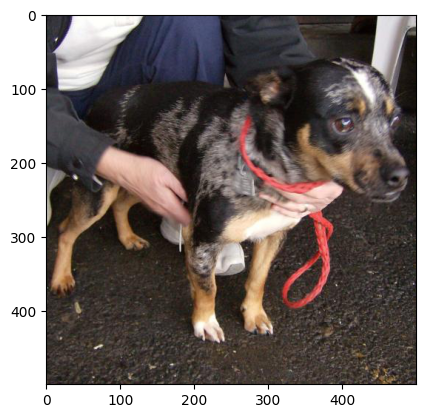

In [6]:
# sample image
image = imread('PetImages/train/dog/10528.jpg')
image.shape
plt.imshow(image)
plt.show()

Image shape: (467, 480, 3)


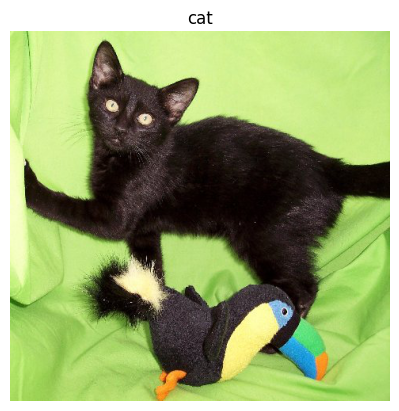

In [7]:
# View a random image
train_dir = './PetImages/train'
test_dir = './PetImages/test'
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+'/'+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img, cmap = "gray")
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

img = view_random_image(target_dir = train_dir, target_class = "cat")
# img = tensorflow.constant(img)
plt.show()


## tensorflow dataset from local images

In [8]:
#
# Setting up the data
#
from tensorflow.keras.preprocessing import image_dataset_from_directory
IMG_SIZE = (224, 224)   # (128, 128)
batchSize=20

print("Training Images:")
train_data = image_dataset_from_directory(directory = train_dir,
                                            image_size = IMG_SIZE,
                                            label_mode = "binary",
                                            color_mode = "rgb",
                                            batch_size = batchSize)

print("Testing Images:")
test_data = image_dataset_from_directory(directory = test_dir,
                                            image_size = IMG_SIZE,
                                            label_mode = "binary",
                                            color_mode = "rgb",
                                            batch_size = batchSize)

# Inspecting the train_data
train_data   # BatchDataset
# <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
# TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


Training Images:
Found 2000 files belonging to 2 classes.
Testing Images:
Found 200 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

## Visualize images from dataset

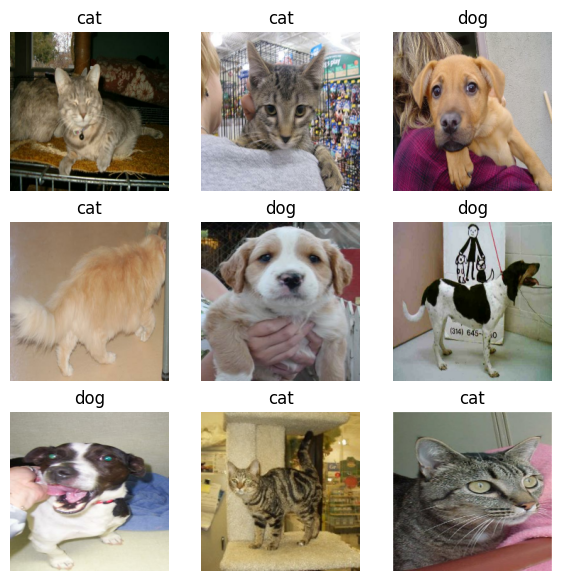

============================== Test dataset ==============================


In [9]:
# Plot images from dataset
# figure 크기를 조절합니다.
plt.figure(figsize=(7, 7))
names = ['cat','dog']
# 배치 하나를 가져옵니다.
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(names[int(labels[i])])
        plt.axis("off")
plt.show()

# [DIY] Plot images from test dataset
print("="*30, 'Test dataset', "="*30)


## Data Augmentation (데이터 증대)
- ### augumentation in a layer

In [10]:
#
# Data augmentation
#
# Create a data augmentation stage with horizontal flipping, rotations, zooms
#
tf.get_logger().setLevel('ERROR')  # Clear warnings in data augmentation

# from tensorflow import keras
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),  # Not compatible with model
  layers.RandomWidth(0.2),
  # layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


### Visualize the augmented images

========================= Train dataset =========================
tf.Tensor(
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]], shape=(20, 1), dtype=float32) (20, 224, 224, 3)
(1, 244, 258, 3)
(1, 246, 220, 3)
(1, 254, 250, 3)
(1, 188, 194, 3)
(1, 248, 192, 3)
(1, 188, 203, 3)
(1, 202, 262, 3)
(1, 266, 252, 3)
(1, 191, 261, 3)


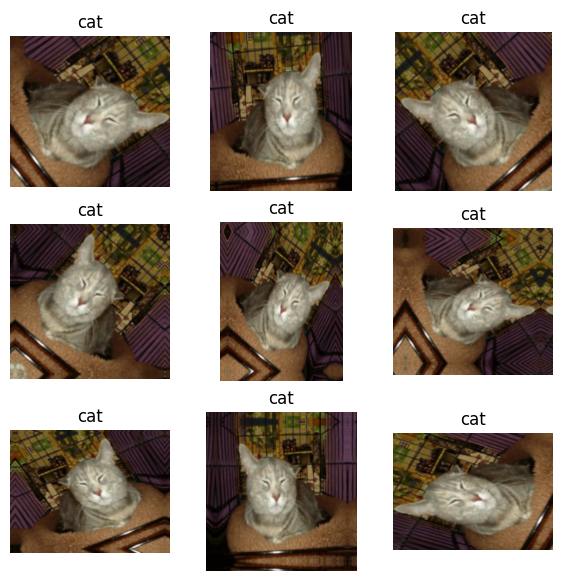

========================= Test dataset =========================
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(20, 1), dtype=float32) (20, 224, 224, 3)
(1, 239, 188, 3)
(1, 246, 255, 3)
(1, 249, 206, 3)
(1, 254, 189, 3)
(1, 208, 216, 3)
(1, 239, 185, 3)
(1, 183, 231, 3)
(1, 237, 217, 3)
(1, 190, 227, 3)


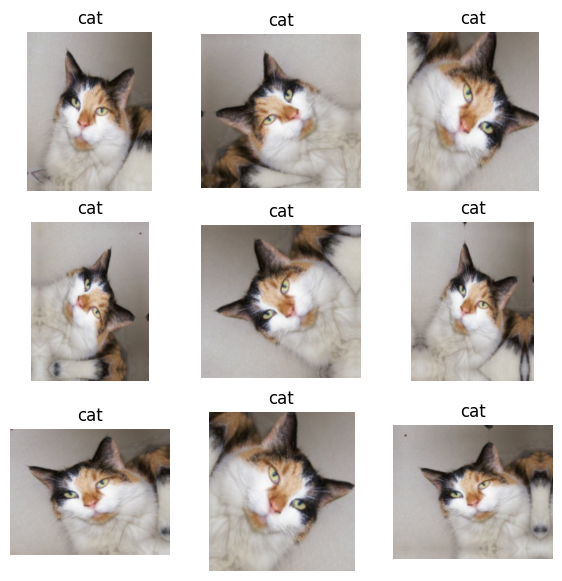

In [11]:
#
# Visualize the augmented images
#
print("="*25, 'Train dataset', "="*25)
plt.figure(figsize=(7,7))
image_idx = 0
for images, labels in train_data.take(1):    # Make a batch of images & labels
    print(labels,images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(images[image_idx], axis=0))
        print(aug_img.shape)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(names[int(labels[image_idx])]))
        plt.axis("off")
    break
plt.show()

print("="*25, 'Test dataset', "="*25)
plt.figure(figsize=(7,7))
image_idx = 0
for images, labels in test_data.take(1):    # Make a batch of images & labels
    print(labels,images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(images[image_idx], axis=0))
        print(aug_img.shape)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(names[int(labels[image_idx])]))
        plt.axis("off")
    break
plt.show()

# Model: Transfer learning
- ## EfficientNet V1 : EfficientNetB1
---
> ### EfficientNet-B1은 EfficientNetV1 계열의 모델 중 하나로, Compound Scaling 방법을 사용해 기초 모델인 EfficientNet-B0에 비해 성능과 효율성이 향상된 모델입니다.  ( from wrtn.ai )

### EfficientNet-B1의 주요 특징은 다음과 같습니다:

1. **가변성**: EfficientNet-B1은 기본 이미지 해상도를 240x240으로 지원하며, 따라서 이보다 크거나 작은 이미지를 처리하기에도 적합합니다.
2. **상대적으로 작은 모델**: 이 모델은 실전 상황에서 쉽게 배포할 수 있는 모델을 제공하며, 컴퓨터 자원에 큰 부담을 주지 않습니다. 그럼에도 불구하고, 비슷한 크기의 다른 모델에 비해 더 높은 성능을 보입니다. 파라미터의 수는 7.8M
3. **복합 스케일링**: EfficientNet-B1은 모델의 깊이, 너비, 그리고 해상도를 각각 조절하는 구조로, 이미지 입력 크기와 파라미터 수를 유연하게 조정할 수 있도록 설계되어 있습니다.
4. **사전 훈련 가중치**: EfficientNet-B1은 ImageNet 데이터셋에서 이미 학습된 가중치를 제공합니다. 이렇게 전이학습에 사용할 수 있는 사전 훈련된 가중치가 있기 때문에 비교적 적은 양의 데이터셋으로부터도 높은 성능의 모델을 학습할 수 있습니다.

- **EfficientNet-B1은 다양한 이미지 분류 작업에 효과적으로 사용될 수 있으며, 소량의 컴퓨팅 파워와 메모리를 사용하여도 높은 성능을 낼 수 있습니다.**
- **전이학습에 유용한 이 모델은 다양한 사례에서 활용될 수 있어, 인기 있는 모델 중 하나** 입니다.
---
> EfficientNetV2는 EfficientNet에서 개선된 모델 계열로서, 합성곱신경망의 성능과 크기의 균형을 더욱 잘 맞추도록 설계되었습니다. EfficientNetV2 모델 계열에는 학습 및 구현을 위한 여러 가지 사이즈와 구성의 모델이 포함되어 있습니다.

## EfficientNetV2 모델 계열에는 다음과 같은 모델들이 있습니다:

- EfficientNetV2-B0: 가장 기본 모델로, 파라미터 수가 약 55M 미만입니다. 이 모델은 기본 디자인을 시작점으로 삼아 이후에 나오는 모델들의 성능과 크기를 조절합니다.
- EfficientNetV2-B1: 약 78M 개의 파라미터를 가진 중간 크기의 모델로, 입력 이미지의 크기는 240×240입니다.
- EfficientNetV2-B2: 약 90M 개의 파라미터를 가진 조금 더 큰 모델로, 입력 이미지의 크기는 260×260입니다.
- EfficientNetV2-B3: 약 122M 개의 파라미터를 가진 크고 강력한 모델로, 입력 이미지의 크기는 300×300입니다.
- EfficientNetV2S: 여러 모델 중 가장 작은 모델로, 입력 이미지의 크기가 224×224이고, 모델 파라미터의 수는 약 20M입니다.
- EfficientNetV2M: 중간 크기의 모델로, 약 305M 개의 파라미터를 가지고 있으며 입력 이미지의 크기는 112×112입니다.
- EfficientNetV2L: 중간 크기의 모델보다 큰 모델로, 약 400M 개의 파라미터를 가지고 있으며 입력 이미지의 크기는 128×128입니다.
> 각 EfficientNetV2 모델은 다양한 요구사항과 자원에 맞게 적합한 크기와 성능을 가지고 있습니다. 이 모델들은 기존의 EfficientNet 계열보다 높은 성능과 효율성을 달성하며, 다양한 작업에서 좋은 결과를 낼 수 있습니다. 그리고, EfficientNetV2 모델들은 이미지넷에서 미리 훈련된 가중치를 가지고 있으므로, 전이 학습에서도 높은 성능을 보입니다.

In [12]:
#
# Transfer learning
#
## Using the model EfficientNetB1 for the first experiment with all the layers trainable
#
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')
# base_model = keras.applications.EfficientNetB1(include_top = False)
base_model.trainable = False # ConvNet ,# True  # Full training
# Check the input and output of the pretraioned model
# print(base_model.input.shape)
# print(base_model.output.shape)

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.trainable, end=", ")


82420632/82420632 [==============================] - 5s 0us/step
0 False, 1 False, 2 False, 3 False, 4 False, 5 False, 6 False, 7 False, 8 False, 9 False, 10 False, 11 False, 12 False, 13 False, 14 False, 15 False, 16 False, 17 False, 18 False, 19 False, 20 False, 21 False, 22 False, 23 False, 24 False, 25 False, 26 False, 27 False, 28 False, 29 False, 30 False, 31 False, 32 False, 33 False, 34 False, 35 False, 36 False, 37 False, 38 False, 39 False, 40 False, 41 False, 42 False, 43 False, 44 False, 45 False, 46 False, 47 False, 48 False, 49 False, 50 False, 51 False, 52 False, 53 False, 54 False, 55 False, 56 False, 57 False, 58 False, 59 False, 60 False, 61 False, 62 False, 63 False, 64 False, 65 False, 66 False, 67 False, 68 False, 69 False, 70 False, 71 False, 72 False, 73 False, 74 False, 75 False, 76 False, 77 False, 78 False, 79 False, 80 False, 81 False, 82 False, 83 False, 84 False, 85 False, 86 False, 87 False, 88 False, 89 False, 90 False, 91 False, 92 False, 93 False, 94 Fa

In [13]:
model = keras.Sequential([
  layers.Input(shape=(224,224,3),name='input_layer'),
#   layers.Rescaling(1./255),
#   layers.UpSampling2D(size=(2, 2)),  # size matching
  data_augmentation,
  # layers.Conv2D(20,3,activation='relu',padding='same'),
  base_model,  #  (None, 1280)
#   layers.GlobalMaxPooling2D(name = "global_max"),  # unnecessary in EfficientNet V2 model
  layers.Dense(128,activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,495,457
Trainable params: 164,097
Non-trainable params: 20,331,360
_________________________________________________________________


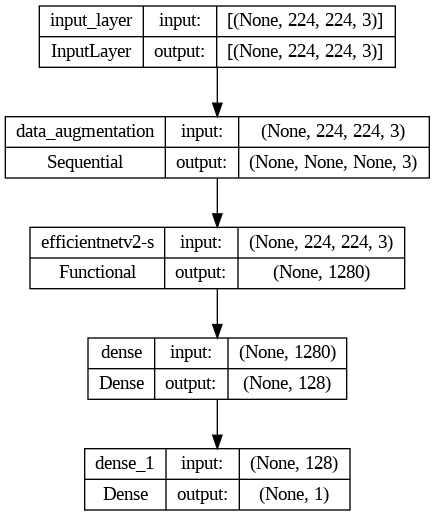

In [14]:
# from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [15]:
len(train_data),len(test_data)  # 2000/20, 200/20, batch_size=20

(100, 10)

# Building the Model

In [16]:
# Setting up the callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5) # if val loss decreases for 5 epochs in a row, stop training
# Creating learning rate reduction callback
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.25, # multiply the learning rate by 0.2 (reduce by 4x)
                                                 patience=3,  # 5
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)
# Check the best model and save the best model
cp_callback = callbacks.ModelCheckpoint(filepath="dogsNcats_TL_efficientNetV2S224ConvNet_best_weights.{epoch:02d}-{val_accuracy:.3f}.hdf5",
                              monitor='val_accuracy', verbose=0, save_best_only=True)

## Check the summary
for no, layer in enumerate(model.layers):
  print(no, layer.trainable)


0 True
1 False
2 True
3 True


In [17]:
######################################################
# Training model using augmentated data
######################################################
#
%%time
history = model.fit(train_data,
                    epochs=100,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = len(test_data), # batchSize,
                    callbacks = [cp_callback, early_stopping, reduce_lr])


Epoch 1/100
100/100 [==============================] - 71s 492ms/step - loss: 0.3127 - accuracy: 0.8755 - val_loss: 0.0484 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 38s 374ms/step - loss: 0.1093 - accuracy: 0.9620 - val_loss: 0.0218 - val_accuracy: 0.9950 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 34s 336ms/step - loss: 0.0654 - accuracy: 0.9785 - val_loss: 0.0208 - val_accuracy: 0.9950 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 32s 316ms/step - loss: 0.0681 - accuracy: 0.9765 - val_loss: 0.0313 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 29s 292ms/step - loss: 0.0830 - accuracy: 0.9685 - val_loss: 0.0203 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - 31s 305ms/step - loss: 0.0622 - accuracy: 0.9760 - val_loss: 0.0141 - val_accuracy: 0.9950 - lr: 1.0000e-04
Epoch 7/100
100/100 [=

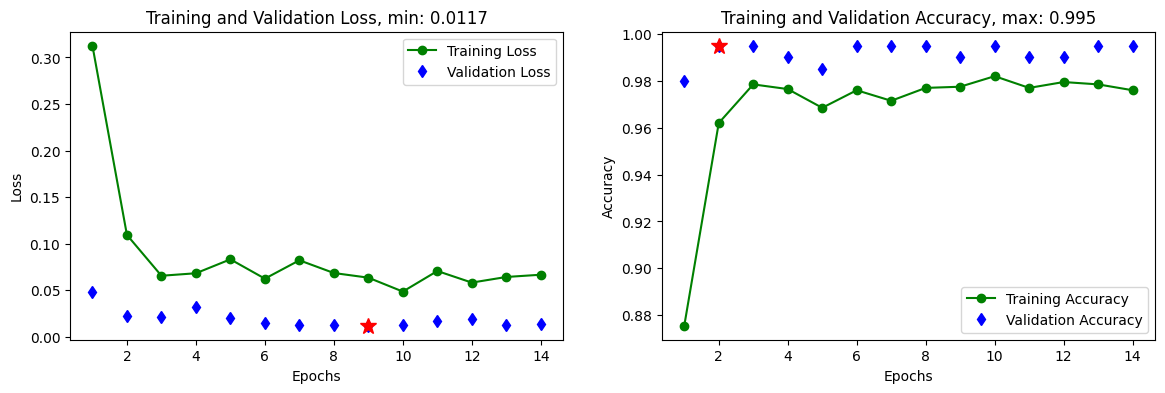

In [18]:
#############################################
# More training graphs
# More graphs of loss and accuracy
# import matplotlib.pyplot as plt
import numpy as np

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Trained well!

---

In [19]:
model.evaluate(test_data)

10/10 [==============================] - 1s 82ms/step - loss: 0.0139 - accuracy: 0.9950


[0.013856299221515656, 0.9950000047683716]

In [20]:
pred = model.predict(test_data)

10/10 [==============================] - 4s 83ms/step


In [21]:
pred.shape,pred[:10]

((200, 1),
 array([[0.9999554 ],
        [0.99928856],
        [0.99961805],
        [0.99993265],
        [0.9999125 ],
        [0.99984074],
        [0.99990237],
        [0.99948406],
        [0.9999832 ],
        [0.00424223]], dtype=float32))

## CONFUSION MATRIX

In [22]:
# Correct-handling with tf_dataset - test_data,unbatch()
from sklearn.metrics import confusion_matrix

y_test=[]
y_pred=[]
for images, labels in test_data.unbatch():   # 개개의 이미지에 대한 예측과 label에 수집
    # print(images.shape,labels.shape)
    y_pred0 = model.predict(np.expand_dims(images, axis=0), verbose=0) #, batch_size=1)
    y_pred.append(np.round(y_pred0[0]))  #, axis=0)
    y_test.append(labels.numpy())
    # break

print(len(y_test),len(y_pred))
# print(y_test.shape,y_pred.shape)

print("정답=", y_test[0])
print("예측값=", y_pred[0]) #, np.round(y_pred0[0]))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

200 200
정답= [0.]
예측값= [0.]
0.995


array([[ 99,   1],
       [  0, 100]])

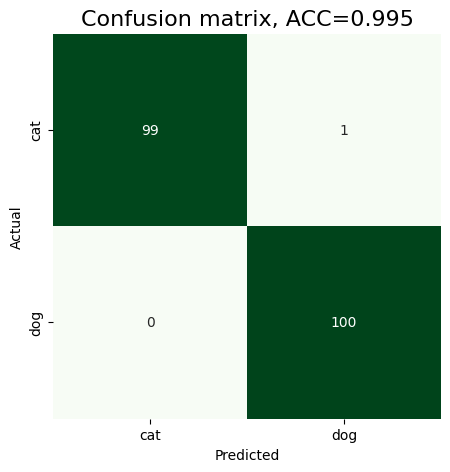

In [23]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm, cbar=False, xticklabels=names, yticklabels=names, fmt='d', annot=True, cmap=plt.cm.Greens) #coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix, ACC={acc}', fontsize=16)
plt.show()

## [DIY] 학습된 best model을 이용해서 혼동행렬을 구하시오.
### Best model saved,
- dogsNcats_TL_efficientNetB1_best_weights.15-0.960.hdf5
- dogsNcats_TL_efficientNetV2S_best_weights.20-0.930.hdf5
- dogsNcats_TL_efficientNetV2S224ConvNet_best_weights.06-0.995.hdf5
- dogsNcats_TL_efficientNetV2S224FullTraining_best_weights.03-0.995.hdf5

In [25]:
from keras.models import load_model

model_best = load_model('dogsNcats_TL_efficientNetV2S224ConvNet_best_weights.02-0.995.hdf5')
# model_best.evaluate(X_test, y_test)  #, batch_size=BATCH_SIZE)

In [26]:
# Correct-handling with tf_dataset - test_data,unbatch()
import tensorflow as tf

y_test=[]
y_pred=[]

X_test = np.empty((224,224,3), int)

# Best model로 전체 테스트 batch에 대하여 다시 예측을 실시함.
for image, label in test_data.unbatch():   # 개개의 이미지에 대한 예측과 label 수집하면서 test 데이터를 X_test 로 저장
    # print(images.shape,labels.shape)
    y_pred0 = model_best.predict(np.expand_dims(image, axis=0), verbose=0) #, batch_size=1)
    y_pred.append(np.round(y_pred0[0]))  #, axis=0)
    y_test.append(label.numpy())
    X_test = np.vstack([X_test,image])  #, axis=0)
#     tf.stack([X_test, image], axis=0)
    # break

X_test = X_test.reshape(-1,224,224,3)
X_test=X_test[1:]
y_test = [int(i) for i in y_test]
y_pred = [int(i) for i in y_pred]
print(len(y_test),len(y_pred), X_test.shape)
# print(y_test.shape,y_pred.shape)

print("정답=", y_test[0])
print("예측값=", y_pred[0]) #, np.round(y_pred0[0]))



200 200 (200, 224, 224, 3)
정답= 0
예측값= 0


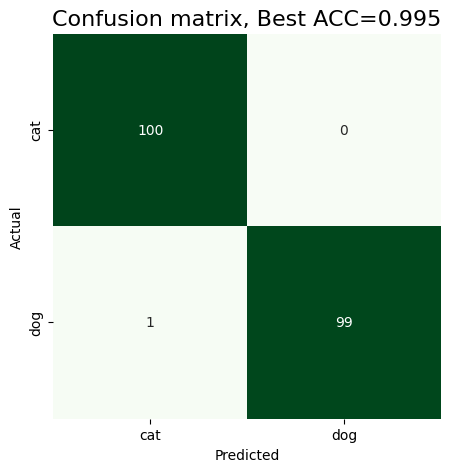

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm, cbar=False, xticklabels=names, yticklabels=names, fmt='d', annot=True, cmap=plt.cm.Greens) #coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix, Best ACC={round(acc,3)}', fontsize=16)
plt.show()

---

## test of the best model

In [28]:
import matplotlib as mpl
def plot_pred(i, predictions, true_labels, img):
    predicted_label, true_label, img = predictions[i], true_labels[i], img[i]
    print(img.shape)
    if predicted_label == true_label:   # np.argmax(true_label)
        mpl.rc('text', color='green')
        print("Test image-%d: Correct!\n" % i)
    else:
        mpl.rc('text', color='red')
        print("Test image-%d: Wrong.\n" % i)

    plt.pause(0.05)
    plt.grid(False)
#     plt.title(names[true_label])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[true_label])
    plt.imshow(img/255.0)


(224, 224, 3)
Test image-35: Correct!



<Figure size 400x400 with 0 Axes>

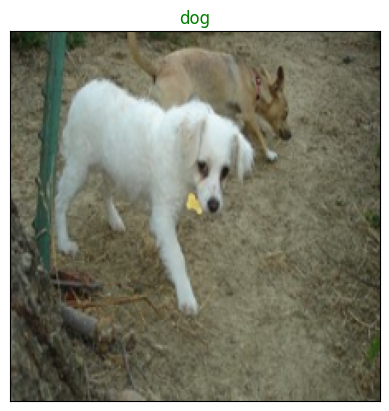

In [29]:
# predictions = model_best.predict(X_test) => y_pred
np.random.seed(None)
num = np.random.randint(0, len(X_test))

plt.figure(figsize=(4, 4))
# plt.subplot(1, 2, (1, 2))
plot_pred(num, y_pred, y_test, X_test)

plt.show()

---
## **전이(전환)학습 방법**
1. 데이터 수집
2. 데이터세트 구성 (train,test,validation): tf.keras.preprocessing.image_dataset_from_directory
3. 데이터 증대 (Data augmentation)
4. 모델 구성: imagenet 모델 연결, 레이어 학습 조건 설정
5. 콜백 조건 설정
6. 모델 학습 및 테스트
    - steps_per_epoch = len(train_data)
    - validation_data = test_data
    - validation_steps = len(test_data)

> steps_per_epoch를 전체데이터의 길이로 설정: 학습 시간이 길어지나 작을 val_loss를 가진 모델을 구할 수 있디.
> validation_steps은 테스트데이터 길이의 25~100으로 조정 가능 %